In [23]:
import warnings


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import catboost
import lightgbm
import xgboost
from tqdm import tqdm

In [24]:
data_test = pd.read_csv('../preprocessed_data/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_Test_Features.csv')  # Test dataset

data_training = pd.read_csv('../preprocessed_data/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_Training_Features.csv') # Train dataset

data_target = pd.read_csv('../preprocessed_data/Flu_Shot_Learning_Predict_H1N1_and_Seasonal_Flu_Vaccines_Training_Labels.csv')

In [26]:
categorical_columns = ['age_group', 'education', 'race', 'sex', 'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region','census_msa']

numerical_columns = [
    'h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance',
    'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings',
    'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1',
    'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months',
    'health_worker', 'opinion_h1n1_vacc_effective',
    'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
    'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
    'household_children']

# Models for H1N1 Vaccine

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_training, data_target['h1n1_vaccine'], test_size=0.2, random_state=42, stratify=data_target['h1n1_vaccine'])

In [28]:
X_train = X_train.drop(columns=['respondent_id'])
X_test = X_test.drop(columns=['respondent_id'])


scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

X_train_final = pd.get_dummies(X_train_scaled, columns=categorical_columns)
X_test_final = pd.get_dummies(X_test_scaled, columns=categorical_columns)

bool_columns_train = X_train_final.select_dtypes(include=['bool']).columns
bool_columns_test = X_test_final.select_dtypes(include=['bool']).columns

X_train_final[bool_columns_train] = X_train_final[bool_columns_train].astype(int)
X_test_final[bool_columns_test] = X_test_final[bool_columns_test].astype(int)


In [29]:
X_train_final.rename(columns={'education_< 12 Years':'education_less 12 Years'}, inplace=True)
X_test_final.rename(columns={'education_< 12 Years':'education_less 12 Years'}, inplace=True)

In [30]:
warnings.simplefilter('ignore')

SEED = 42

models_params = {

    'LogisticRegression': (LogisticRegression(solver='liblinear', max_iter=10000), {

        'C': [0.01, 0.1, 1, 10, 100],

        'penalty': ['l1', 'l2']

    }),

    'RandomForest': (RandomForestClassifier(random_state=SEED), {

        'n_estimators': [10, 50, 100, 200],

        'max_depth': [None, 5, 10, 15, 20],

        'min_samples_leaf': [1, 5, 10],

        'max_features': ['auto', 'sqrt', 'log2']

    }),

    'KNeighbors': (KNeighborsClassifier(weights="distance"), {

        'n_neighbors': [3, 5, 7, 10],

        'leaf_size': [15, 30, 45],

        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']

    }),

    'CatBoost': (catboost.CatBoostClassifier(verbose=0, random_seed=SEED), {

        'depth': [4, 6, 8, 10],

        'iterations': [50, 100, 200],

        'learning_rate': [0.01, 0.1, 0.5]

    }),

    'XGB': (xgboost.XGBClassifier(random_state=SEED), {

        'max_depth': [3, 5, 7, 9],

        'n_estimators': [50, 100, 200],

        'learning_rate': [0.01, 0.1, 0.5],

        'subsample': [0.6, 0.8, 1.0]

    }),

    'XGB_RF': (xgboost.XGBRFClassifier(random_state=SEED), {

        'n_estimators': [10, 50, 100],

        'subsample': [0.6, 0.8, 1.0]

    }),

    'GaussianNB': (GaussianNB(), {})

}

best_models = {}
roc_auc_scores = {}

for model_name, (model, params) in tqdm(models_params.items(), desc="Running Models"):
    grid_search = GridSearchCV(model, params, scoring='roc_auc', cv=5)
    grid_search.fit(X_train_final, y_train)

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_

    best_models[model_name] = best_model
    roc_auc_scores[model_name] = best_score
    print(f"{model_name}: Best Score = {best_score}, Best Params = {grid_search.best_params_}")


Running Models:  14%|█▍        | 1/7 [00:55<05:35, 55.86s/it]

LogisticRegression: Best Score = 0.8297309869806704, Best Params = {'C': 0.1, 'penalty': 'l1'}


Running Models:  29%|██▊       | 2/7 [17:09<49:38, 595.69s/it]

RandomForest: Best Score = 0.8307764257326238, Best Params = {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 200}


Running Models:  43%|████▎     | 3/7 [38:35<1:00:43, 910.81s/it]

KNeighbors: Best Score = 0.7783443229002236, Best Params = {'algorithm': 'auto', 'leaf_size': 15, 'n_neighbors': 10}


Running Models:  57%|█████▋    | 4/7 [43:03<32:51, 657.24s/it]  

CatBoost: Best Score = 0.8358090839513903, Best Params = {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}


Running Models:  71%|███████▏  | 5/7 [48:20<17:48, 534.49s/it]

XGB: Best Score = 0.8360547466386417, Best Params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


Running Models:  86%|████████▌ | 6/7 [48:34<05:57, 357.64s/it]

XGB_RF: Best Score = 0.8278430065894007, Best Params = {'n_estimators': 100, 'subsample': 0.6}


Running Models: 100%|██████████| 7/7 [48:35<00:00, 416.48s/it]

GaussianNB: Best Score = 0.7835121982720971, Best Params = {}


In [31]:
print("Best Models and their ROC AUC Scores:")
for model_name, score in roc_auc_scores.items():
    print(f"{model_name}: {score}")

Best Models and their ROC AUC Scores:
LogisticRegression: 0.8297309869806704
RandomForest: 0.8307764257326238
KNeighbors: 0.7783443229002236
CatBoost: 0.8358090839513903
XGB: 0.8360547466386417
XGB_RF: 0.8278430065894007
GaussianNB: 0.7835121982720971


In [32]:
best_model_name = max(roc_auc_scores, key=roc_auc_scores.get)
best_model = best_models[best_model_name]
print(f"Best Model: {best_model_name} с AUC = {roc_auc_scores[best_model_name]}")

Best Model: XGB с AUC = 0.8360547466386417


In [33]:
roc_auc_scores_pred = {}

for model_name, model in best_models.items():
    
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)

    roc_auc_scores_pred[model_name] = roc_auc

    print(f"{model_name}: ROC AUC = {roc_auc:.4f}")


LogisticRegression: ROC AUC = 0.8216
RandomForest: ROC AUC = 0.8254
KNeighbors: ROC AUC = 0.7733
CatBoost: ROC AUC = 0.8310
XGB: ROC AUC = 0.8313
XGB_RF: ROC AUC = 0.8203
GaussianNB: ROC AUC = 0.7754


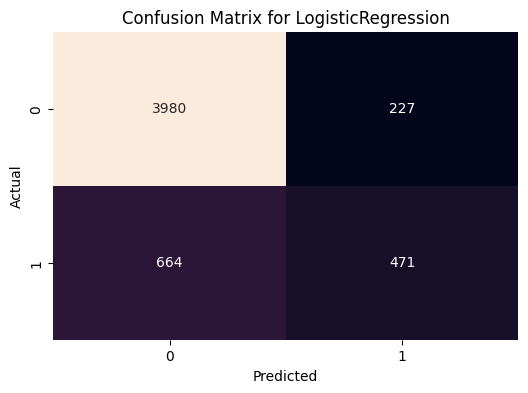

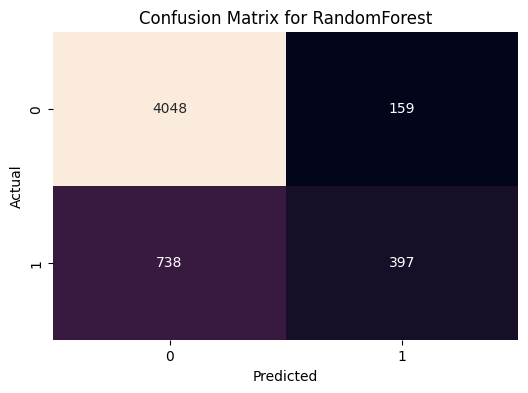

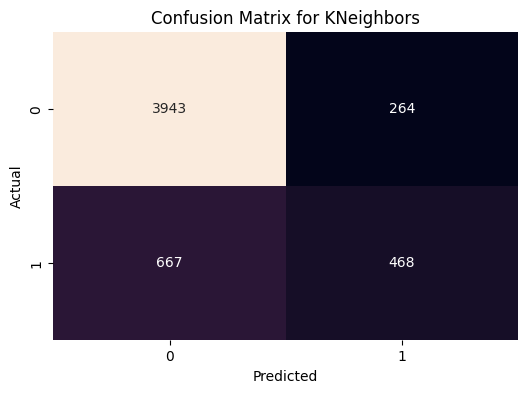

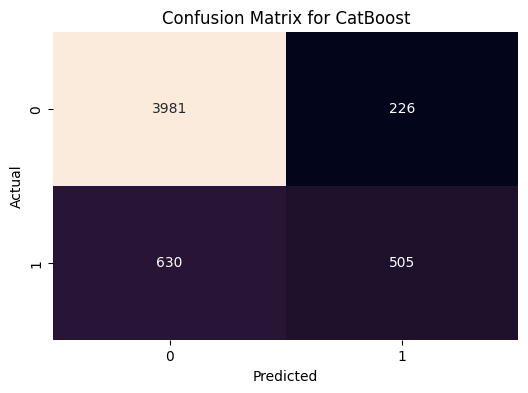

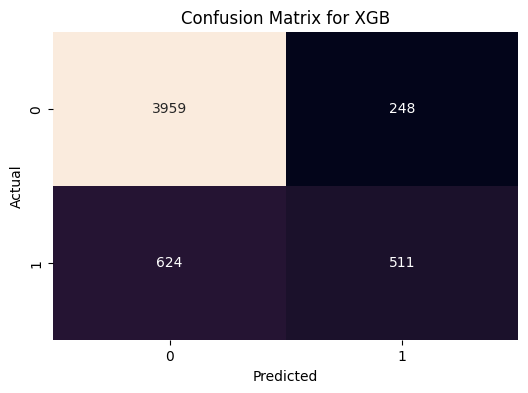

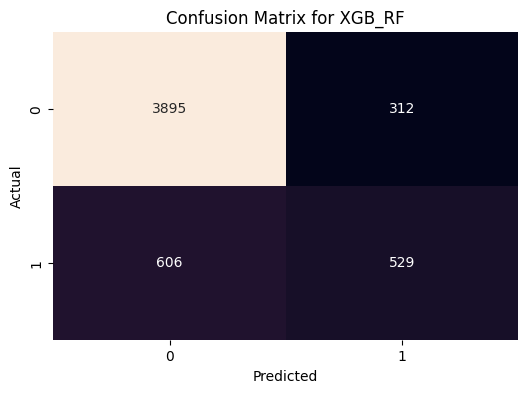

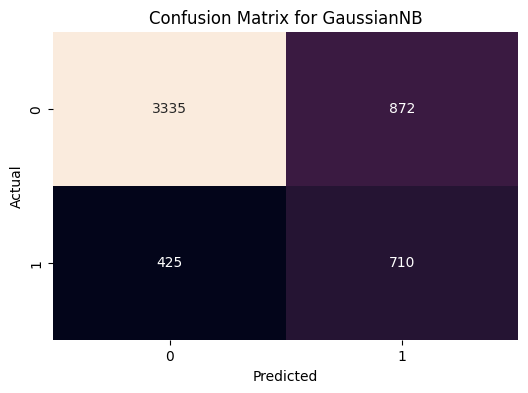

In [34]:
for model_name, model in best_models.items():
    
    y_pred = model.predict(X_test_final)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Models for Seasonal Vaccine

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data_training, data_target['seasonal_vaccine'], test_size=0.2, random_state=42, stratify=data_target['seasonal_vaccine'])

In [37]:
X_train = X_train.drop(columns=['respondent_id'])
X_test = X_test.drop(columns=['respondent_id'])


scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test_scaled[numerical_columns] = scaler.transform(X_test[numerical_columns])

X_train_final = pd.get_dummies(X_train_scaled, columns=categorical_columns)
X_test_final = pd.get_dummies(X_test_scaled, columns=categorical_columns)

bool_columns_train = X_train_final.select_dtypes(include=['bool']).columns
bool_columns_test = X_test_final.select_dtypes(include=['bool']).columns

X_train_final[bool_columns_train] = X_train_final[bool_columns_train].astype(int)
X_test_final[bool_columns_test] = X_test_final[bool_columns_test].astype(int)

In [38]:
X_train_final.rename(columns={'education_< 12 Years':'education_less 12 Years'}, inplace=True)
X_test_final.rename(columns={'education_< 12 Years':'education_less 12 Years'}, inplace=True)

In [39]:
SEED = 42

models_params = {

    'LogisticRegression': (LogisticRegression(solver='liblinear', max_iter=10000), {

        'C': [0.01, 0.1, 1, 10, 100],

        'penalty': ['l1', 'l2']

    }),

    'RandomForest': (RandomForestClassifier(random_state=SEED), {

        'n_estimators': [10, 50, 100, 200],

        'max_depth': [None, 5, 10, 15, 20],

        'min_samples_leaf': [1, 5, 10],

        'max_features': ['auto', 'sqrt', 'log2']

    }),

    'KNeighbors': (KNeighborsClassifier(weights="distance"), {

        'n_neighbors': [3, 5, 7, 10],

        'leaf_size': [15, 30, 45],

        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']

    }),

    'CatBoost': (catboost.CatBoostClassifier(verbose=0, random_seed=SEED), {

        'depth': [4, 6, 8, 10],

        'iterations': [50, 100, 200],

        'learning_rate': [0.01, 0.1, 0.5]

    }),

    'XGB': (xgboost.XGBClassifier(random_state=SEED), {

        'max_depth': [3, 5, 7, 9],

        'n_estimators': [50, 100, 200],

        'learning_rate': [0.01, 0.1, 0.5],

        'subsample': [0.6, 0.8, 1.0]

    }),

    'XGB_RF': (xgboost.XGBRFClassifier(random_state=SEED), {

        'n_estimators': [10, 50, 100],

        'subsample': [0.6, 0.8, 1.0]

    }),

    'GaussianNB': (GaussianNB(), {})

}

best_models_seasonal_vac = {}
roc_auc_scores_seasonal_vac = {}

for model_name, (model, params) in tqdm(models_params.items(), desc="Running Models"):
    grid_search = GridSearchCV(model, params, scoring='roc_auc', cv=5)
    grid_search.fit(X_train_final, y_train)

    best_model = grid_search.best_estimator_
    best_score = grid_search.best_score_

    best_models_seasonal_vac[model_name] = best_model
    roc_auc_scores_seasonal_vac[model_name] = best_score
    print(f"{model_name}: Best Score = {best_score}, Best Params = {grid_search.best_params_}")

Running Models:  14%|█▍        | 1/7 [00:18<01:48, 18.06s/it]

LogisticRegression: Best Score = 0.8448630974407603, Best Params = {'C': 0.1, 'penalty': 'l2'}


Running Models:  29%|██▊       | 2/7 [16:43<48:56, 587.32s/it]

RandomForest: Best Score = 0.8478813025341527, Best Params = {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 200}


Running Models:  43%|████▎     | 3/7 [39:11<1:02:18, 934.69s/it]

KNeighbors: Best Score = 0.7972005145516815, Best Params = {'algorithm': 'auto', 'leaf_size': 15, 'n_neighbors': 10}


Running Models:  57%|█████▋    | 4/7 [43:26<33:18, 666.17s/it]  

CatBoost: Best Score = 0.8525088240798239, Best Params = {'depth': 4, 'iterations': 200, 'learning_rate': 0.1}


Running Models:  71%|███████▏  | 5/7 [48:59<18:12, 546.12s/it]

XGB: Best Score = 0.8530796842703031, Best Params = {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


Running Models:  86%|████████▌ | 6/7 [49:14<06:05, 365.31s/it]

XGB_RF: Best Score = 0.838480813124899, Best Params = {'n_estimators': 100, 'subsample': 0.6}


Running Models: 100%|██████████| 7/7 [49:14<00:00, 422.07s/it]

GaussianNB: Best Score = 0.7941455852719923, Best Params = {}


In [40]:
print("Best Models and their ROC AUC Scores:")
for model_name, score in roc_auc_scores_seasonal_vac.items():
    print(f"{model_name}: {score}")

Best Models and their ROC AUC Scores:
LogisticRegression: 0.8448630974407603
RandomForest: 0.8478813025341527
KNeighbors: 0.7972005145516815
CatBoost: 0.8525088240798239
XGB: 0.8530796842703031
XGB_RF: 0.838480813124899
GaussianNB: 0.7941455852719923


In [41]:
best_model_name_seasonal_vac = max(roc_auc_scores_seasonal_vac, key=roc_auc_scores.get)
best_model_seasonal_vac = best_models_seasonal_vac[best_model_name_seasonal_vac]
print(f"Best Model: {best_model_name_seasonal_vac} с AUC = {roc_auc_scores_seasonal_vac[best_model_name_seasonal_vac]}")

Best Model: XGB с AUC = 0.8530796842703031


In [42]:
roc_auc_scores_seasonal_vac_pred = {}

for model_name, model in best_models_seasonal_vac.items():
    
    y_pred_proba = model.predict_proba(X_test_final)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)

    roc_auc_scores_seasonal_vac_pred[model_name] = roc_auc

    print(f"{model_name}: ROC AUC = {roc_auc:.4f}")

LogisticRegression: ROC AUC = 0.8485
RandomForest: ROC AUC = 0.8514
KNeighbors: ROC AUC = 0.8077
CatBoost: ROC AUC = 0.8567
XGB: ROC AUC = 0.8561
XGB_RF: ROC AUC = 0.8417
GaussianNB: ROC AUC = 0.7927


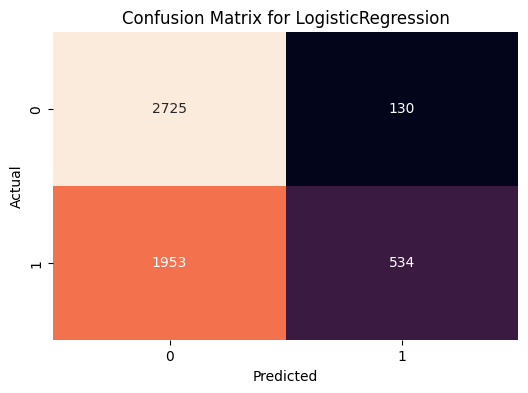

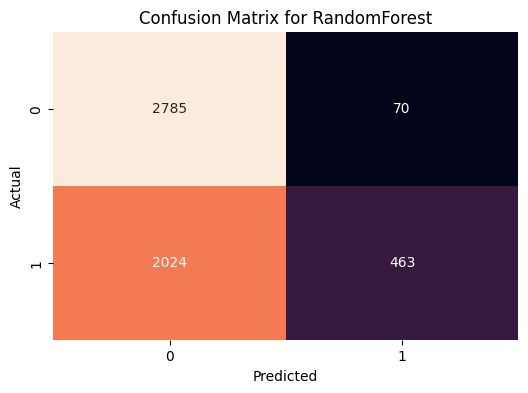

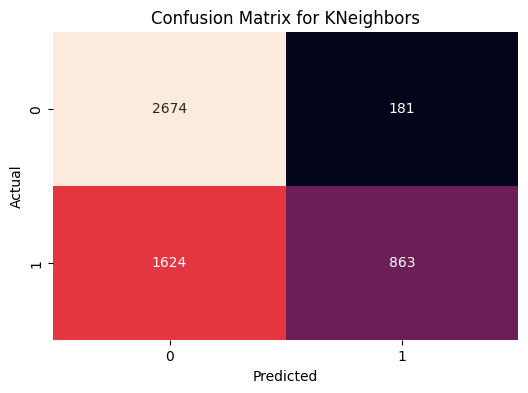

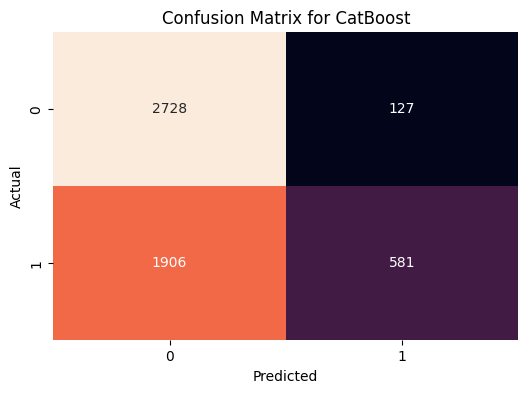

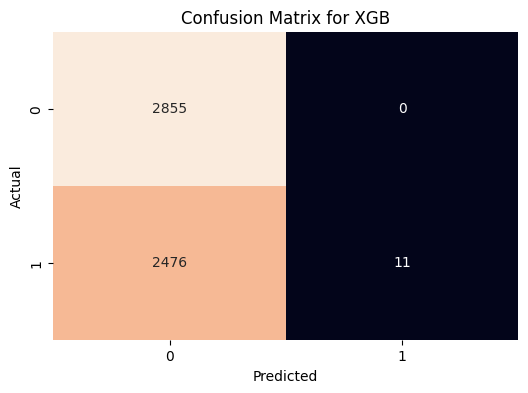

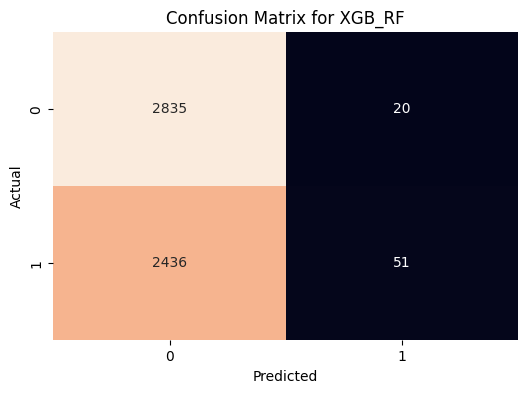

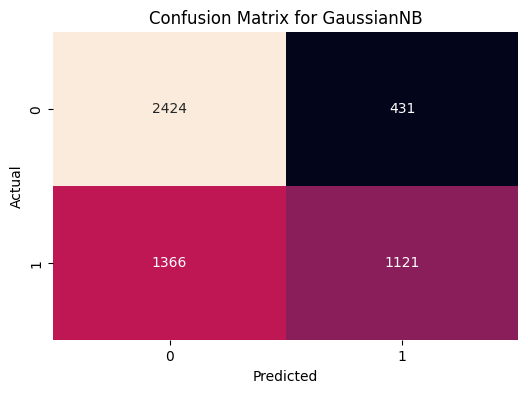

In [43]:
for model_name, model in best_models.items():
    
    y_pred = model.predict(X_test_final)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# SHAP values

In [47]:
best_models

{'LogisticRegression': LogisticRegression(C=0.1, max_iter=10000, penalty='l1', solver='liblinear'),
 'RandomForest': RandomForestClassifier(min_samples_leaf=10, n_estimators=200, random_state=42),
 'KNeighbors': KNeighborsClassifier(leaf_size=15, n_neighbors=10, weights='distance'),
 'CatBoost': <catboost.core.CatBoostClassifier at 0x1437a8440>,
 'XGB': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
           

100%|===================| 21325/21365 [01:02<00:00]        

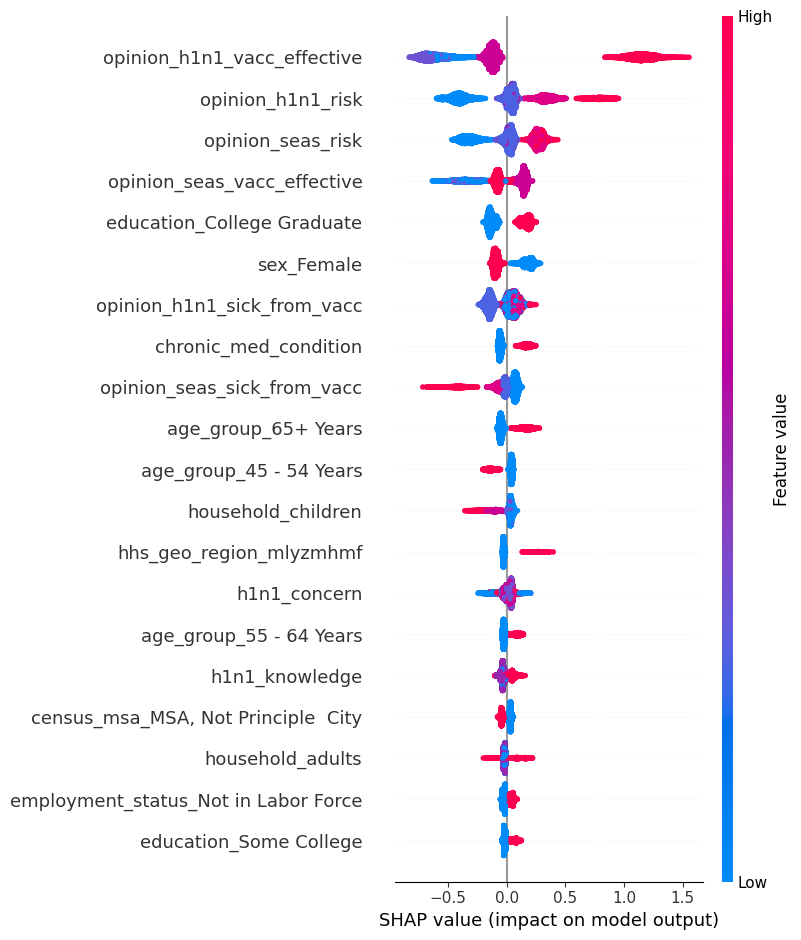

In [48]:
explainer = shap.Explainer(best_models['XGB'], X_train_final)
shap_values = explainer(X_train_final)
shap.summary_plot(shap_values, X_train_final)

100%|===================| 21305/21365 [02:04<00:00]        

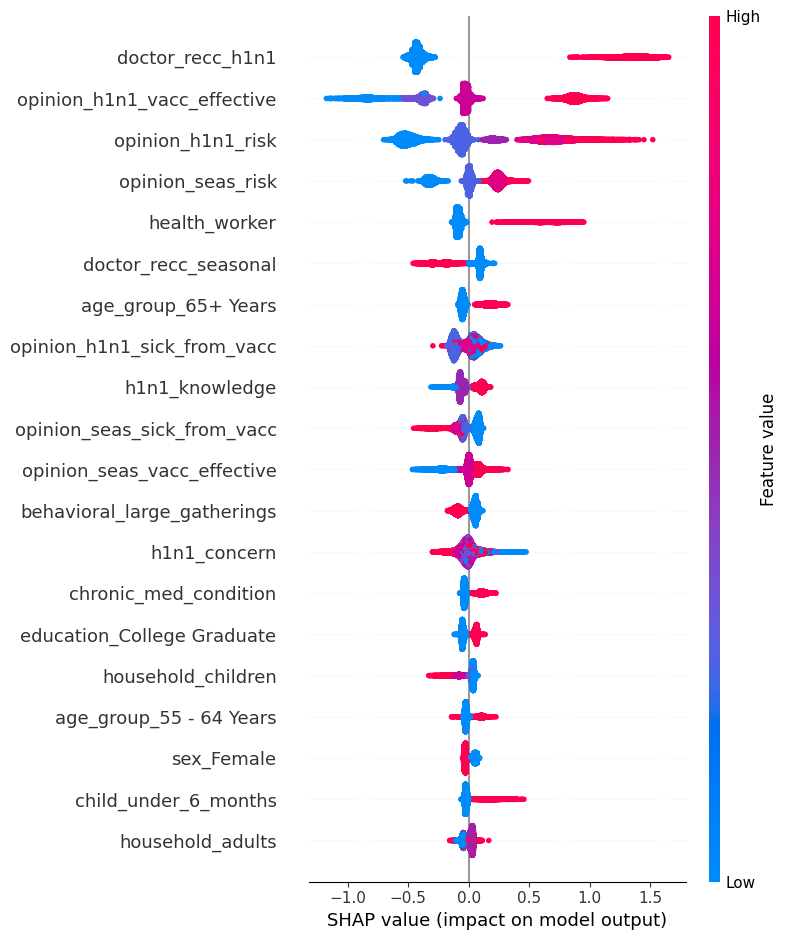

In [49]:
explainer = shap.Explainer(best_models['CatBoost'], X_train_final)
shap_values = explainer(X_train_final)
shap.summary_plot(shap_values, X_train_final)

100%|===================| 21323/21365 [02:06<00:00]        

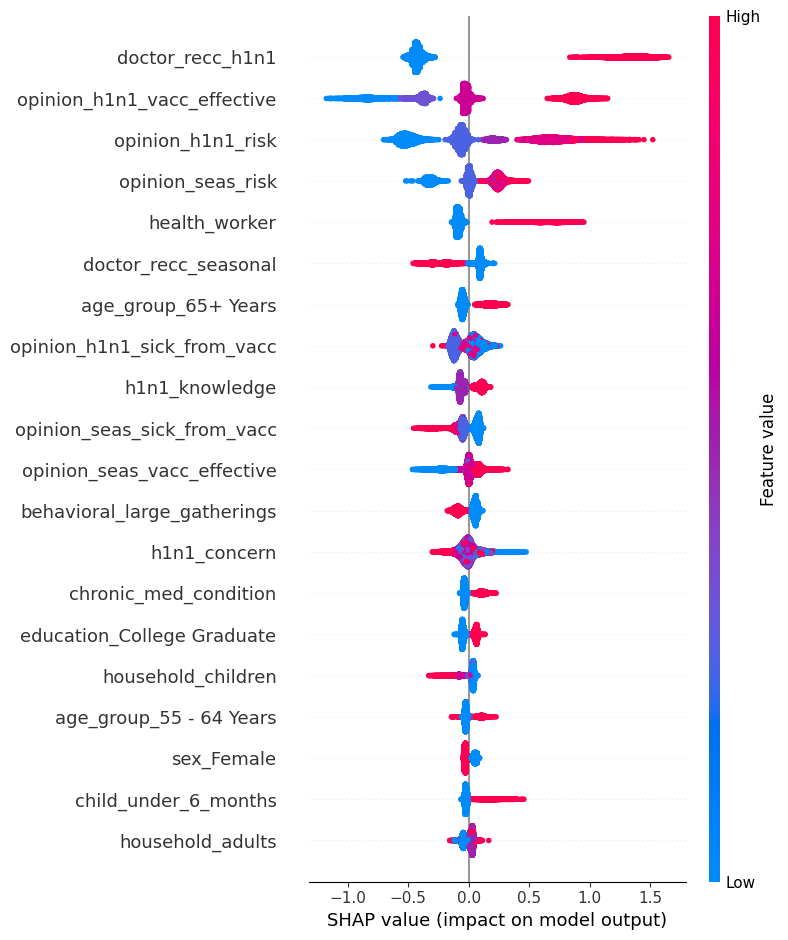

In [50]:
explainer_seasonal_vac = shap.Explainer(best_models_seasonal_vac['XGB'], X_train_final)
shap_values_seasonal_vac = explainer(X_train_final)
shap.summary_plot(shap_values_seasonal_vac, X_train_final)

 99%|===================| 21256/21365 [02:11<00:00]        

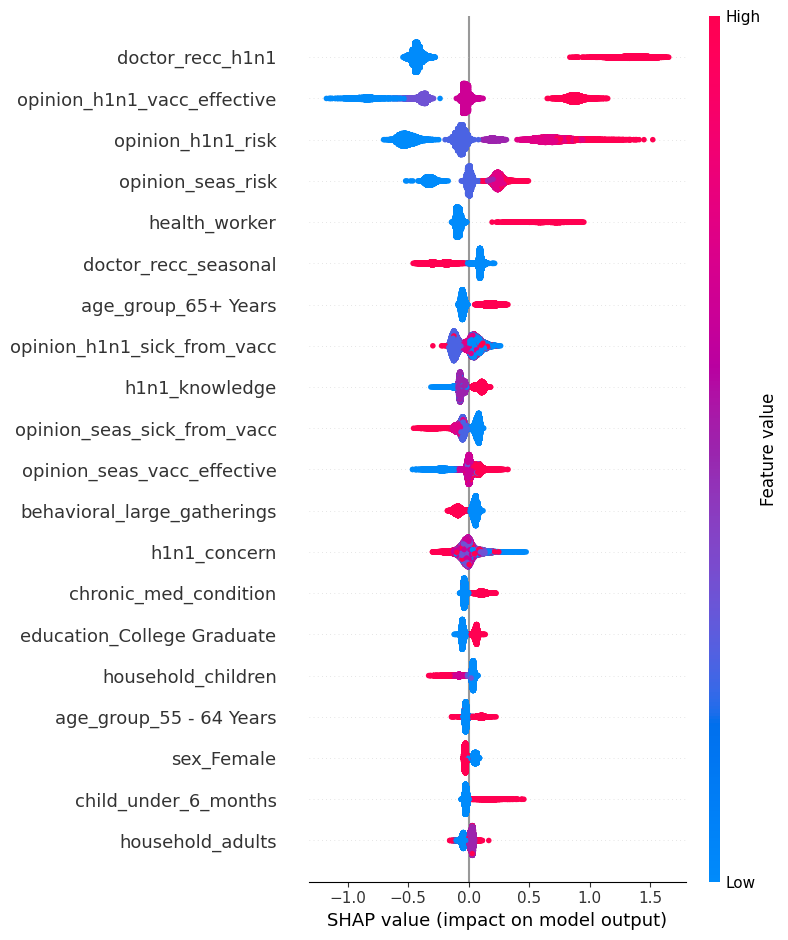

In [51]:
explainer_seasonal_vac = shap.Explainer(best_models_seasonal_vac['CatBoost'], X_train_final)
shap_values_seasonal_vac = explainer(X_train_final)
shap.summary_plot(shap_values_seasonal_vac, X_train_final)